In [1]:
from io import BytesIO
from itertools import combinations

import ase.io as aio
import pandas as pd
from IPython.display import SVG, display
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles]

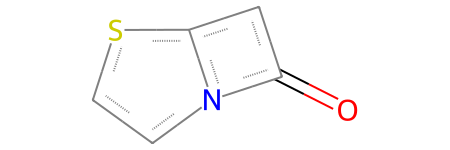

In [3]:
patt = Chem.MolFromSmarts("O=C1CC2N1CC[S;X2]2")
patt

In [4]:
penicillin_analogues = [mol for mol in mols if mol.HasSubstructMatch(patt)]
len(penicillin_analogues)

22

In [5]:
def get_highlightable_atoms(mol, *patterns):
    atom_indices = []
    for patt in patterns:
        matches = mol.GetSubstructMatches(patt)
        # want a flat list of indices, not a list of tuples
        atom_indices.extend([i for match in matches for i in match])
    if len(atom_indices) == 0:
        return None
    return atom_indices


def get_higlightable_bonds(mol, *patterns):
    bond_indices = []
    for patt in patterns:
        matches = mol.GetSubstructMatches(patt)
        for match in matches:
            for i, j in combinations(match, 2):
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bond_indices.append(bond.GetIdx())
    if len(bond_indices) == 0:
        return None
    return bond_indices


def show_mol(d2d, mol, legend="", highlightAtoms=[], highlightBonds=[], image_type="png"):
    d2d.DrawMolecule(mol, legend=legend, highlightAtoms=highlightAtoms, highlightBonds=highlightBonds)
    d2d.FinishDrawing()
    if image_type == "png":
        bio = BytesIO(d2d.GetDrawingText())
        return Image.open(bio)
    elif image_type == "svg":
        svg = d2d.GetDrawingText()
        display(SVG(svg))


def show_images(imgs, buffer=5):
    height = 0
    width = 0
    for img in imgs:
        height = max(height, img.height)
        width += img.width
    width += buffer * (len(imgs) - 1)
    res = Image.new("RGBA", (width, height))
    x = 0
    for img in imgs:
        res.paste(img, (x, 0))
        x += img.width + buffer
    return res

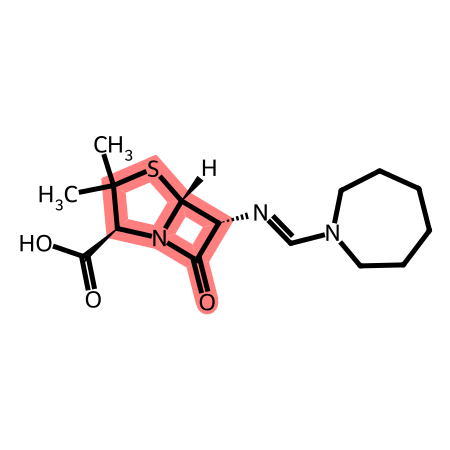

In [8]:
d2d = Draw.MolDraw2DSVG(450,450)
dopts = d2d.drawOptions()
dopts.baseFontSize = 0.8
dopts.bondLineWidth = 5.0
dopts.useBWAtomPalette()
dopts.explicitMethyl = True
mol = penicillin_analogues[0]
show_mol(d2d, mol, highlightAtoms=get_highlightable_atoms(mol, patt), highlightBonds=get_higlightable_bonds(mol, patt), image_type="svg")

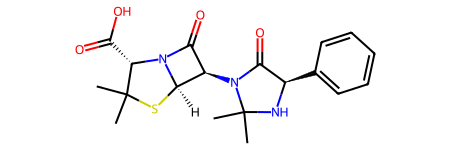

In [11]:
penicillin_analogues[11]